# Codificador Automático

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from tensorflow import keras
from tqdm import tqdm
import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

from utils.helper import (
    folder_to_sequence,
    df_to_sequence,
    Calibrator,
    MinMaxScaler_AE,
    train_test_split_ae,
)

from keras.models import Sequential
from keras.layers import (
    Dense,
    LSTM,
    Input,
    RepeatVector,
    TimeDistributed,
    Flatten,
    Dropout,
)

plt.style.use(["science", "ieee", "notebook"])

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.figsize"] = (9, 4)

In [5]:
from getpass import getpass

os.environ["NEPTUNE_API_TOKEN"] = getpass("Enter your Neptune API token: ")
os.environ["NEPTUNE_PROJECT"] = getpass("Enter your project name:")

In [24]:
run = neptune.init_run()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vinimelloemuller/TCC/e/TCC-2


In [25]:
calibrator = Calibrator()
scaler = MinMaxScaler_AE()

In [26]:
params = {
    "window_size": 30,
}
run["parameters"] = params

In [27]:
window_size = params["window_size"]
bigX = folder_to_sequence("VIDRO-B3", window_size=window_size)
print("data shape: ", bigX.shape)

100%|██████████| 27/27 [00:03<00:00,  8.25it/s]

data shape:  (32734, 30, 1)


In [13]:
Xtrain, Xval = train_test_split_ae(bigX)
scaler.fit(bigX)

Xtrain_N, Xval_N = scaler.transform(Xtrain), scaler.transform(Xval)

In [16]:
# teste 1
autoencoder = Sequential(
    [
        Input((None, 1)),  # Indica que as séries temporais são de apenas uma feature
        LSTM(window_size // 2, return_sequences=False),
        Dropout(0.2),
        RepeatVector(window_size),
        LSTM(window_size // 2, return_sequences=True),
        Dropout(0.2),
        TimeDistributed(Dense(1, activation="linear")),
        Flatten(),
    ]
)

In [17]:
autoencoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 20, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20, 10)         │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 1)          │            11 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331 (5.20 KB)

 Trainable params: 1,331 (5.20 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        save_best_only=True,
        monitor="val_loss",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=1e-5
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=80, verbose=1),
    NeptuneCallback(run=run, base_namespace="metrics"),
]

autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")

history = autoencoder.fit(
    Xtrain_N,
    Xtrain_N,
    validation_data=(Xval_N, Xval_N),
    epochs=500,
    batch_size=64,
    shuffle=True,
    callbacks=callbacks,
)

Epoch 1/500
387/387 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0711 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 2/500
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0102 - val_loss: 7.8622e-04 - learning_rate: 0.0010
Epoch 3/500
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0070 - val_loss: 5.1581e-04 - learning_rate: 0.0010
Epoch 4/500
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0053 - val_loss: 5.1855e-04 - learning_rate: 0.0010
Epoch 5/500
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0041 - val_loss: 5.4807e-04 - learning_rate: 0.0010
Epoch 6/500
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0034 - val_loss: 5.6043e-04 - learning_rate: 0.0010
Epoch 7/500
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0029 - val_loss: 4.9284e-04 - learning_rate: 0.0010
Epoch 8/500
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0026 - val_loss: 4.1898e-04 - learning_rate: 0.0010
Epoch 9/500
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0023 - val_loss: 4.0

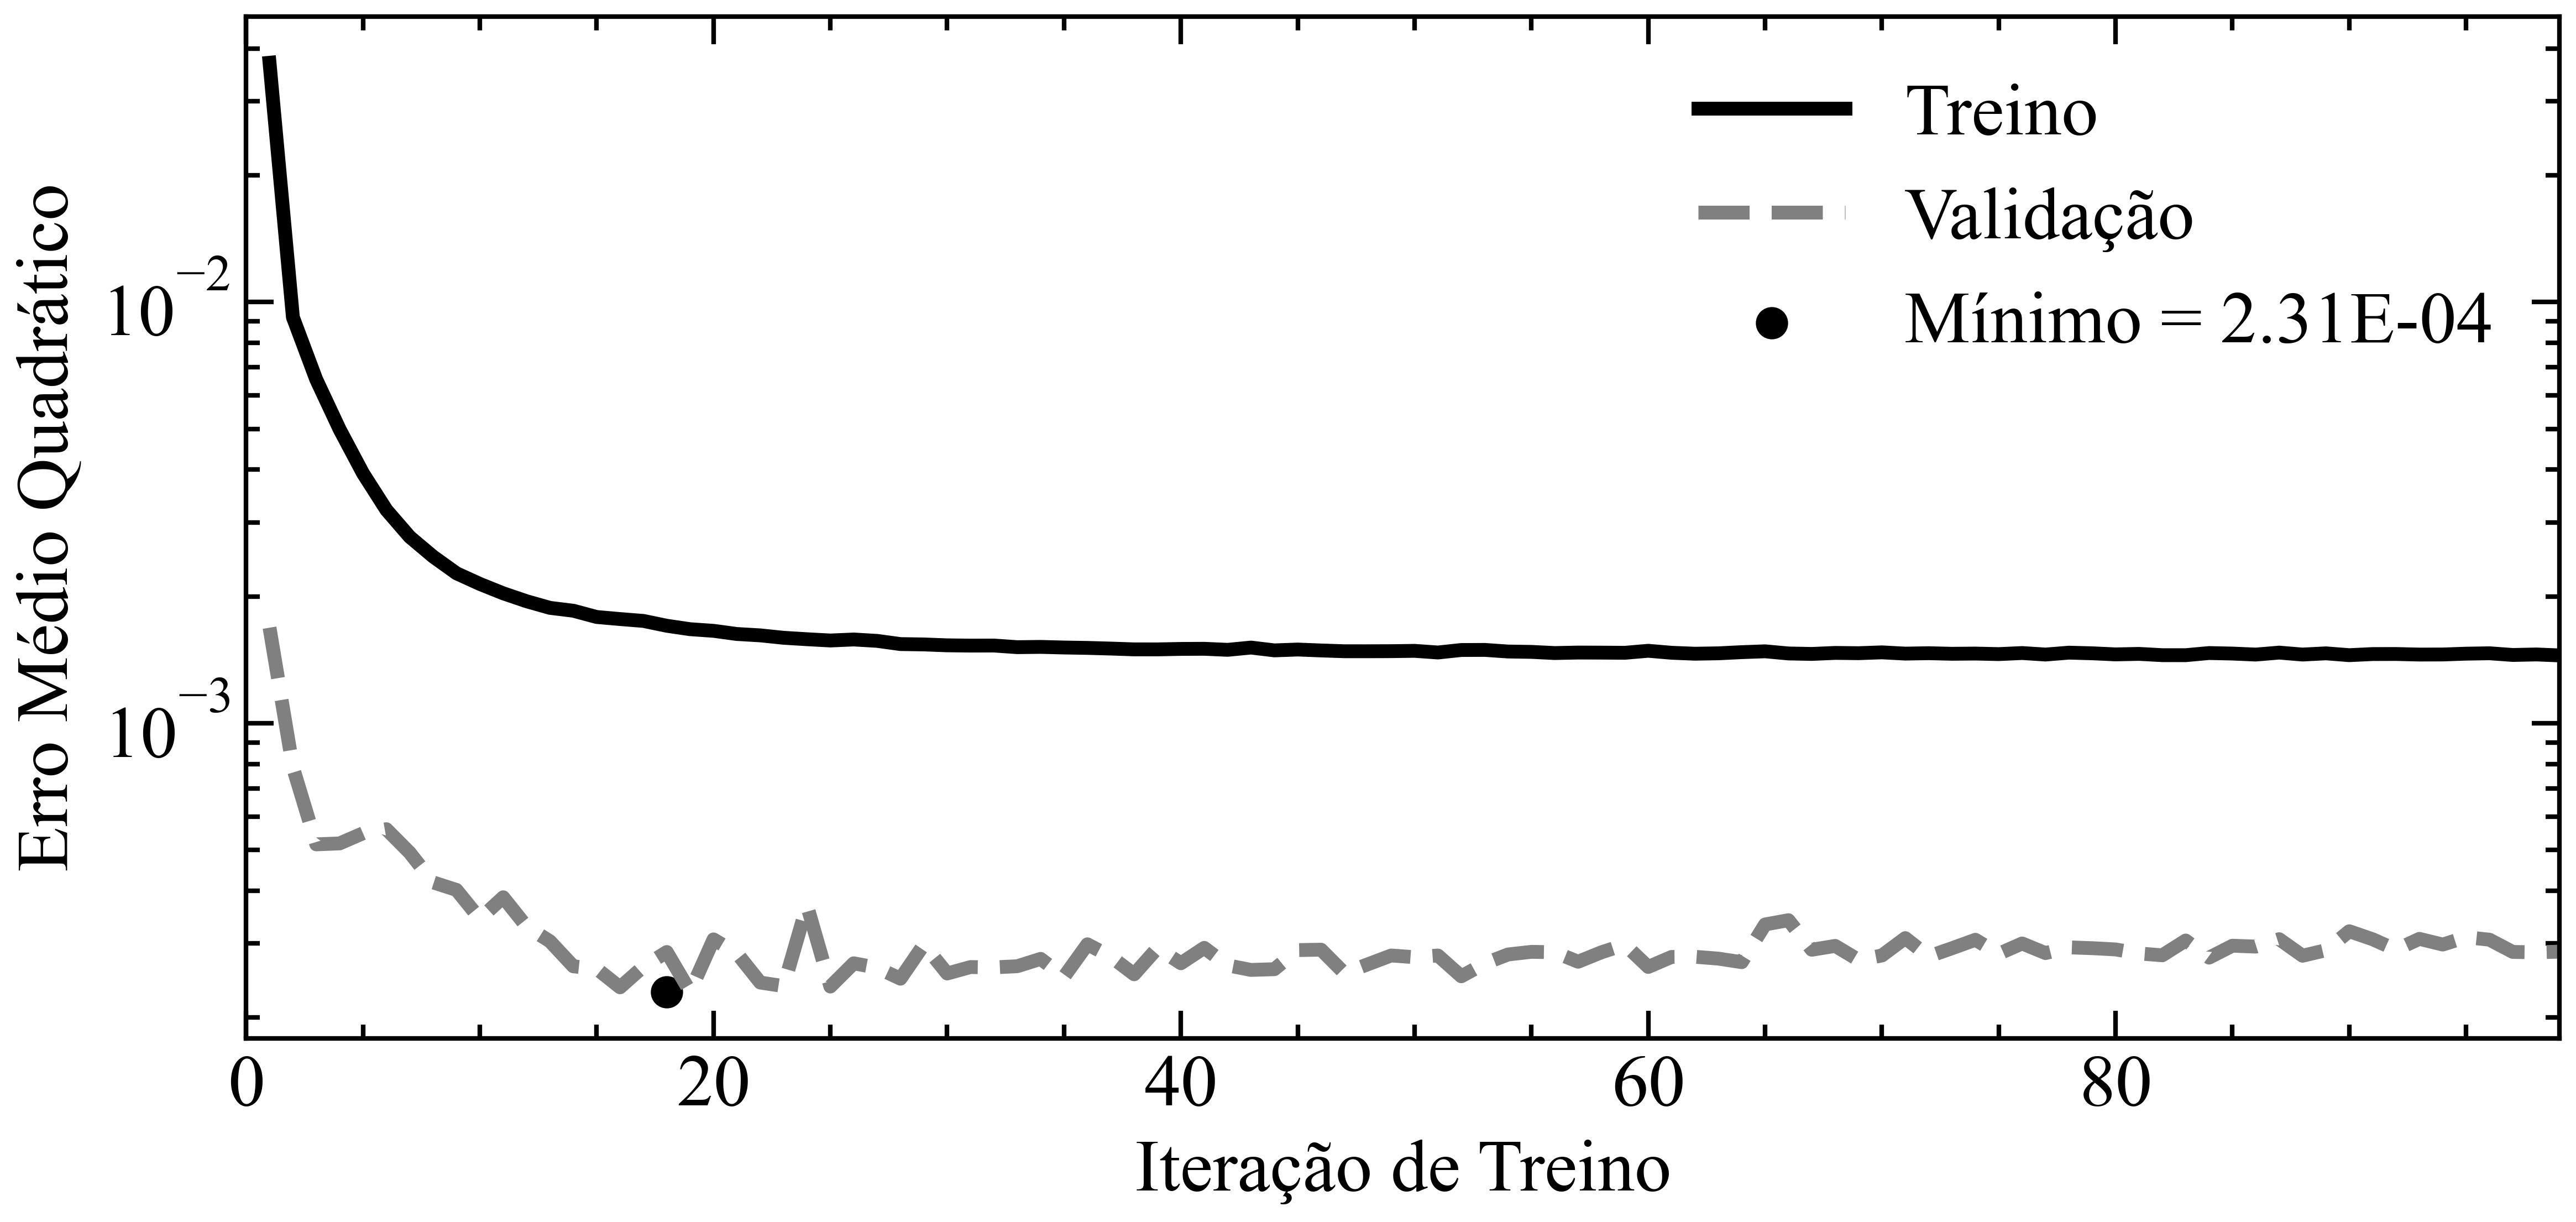

In [19]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = np.arange(1, len(loss) + 1)

plt.yscale("log", base=10)
plt.plot(epochs, loss, c="k", label="Treino", lw=3)
plt.plot(epochs, val_loss, c="grey", label="Validação", lw=3)
plt.scatter(
    np.argmin(val_loss), np.min(val_loss), label=f"Mínimo = {np.min(val_loss):.2E}"
)
plt.ylabel("Erro Médio Quadrático")
plt.xlabel("Iteração de Treino")
plt.xlim((0, len(loss)))
plt.legend()

plt.savefig("images/curva-de-aprendizdo.pdf", dpi=300, bbox_inches="tight")

In [22]:
run["model"].track_files("best_model.keras")

In [20]:
predictions = autoencoder.predict(Xtrain_N)

774/774 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


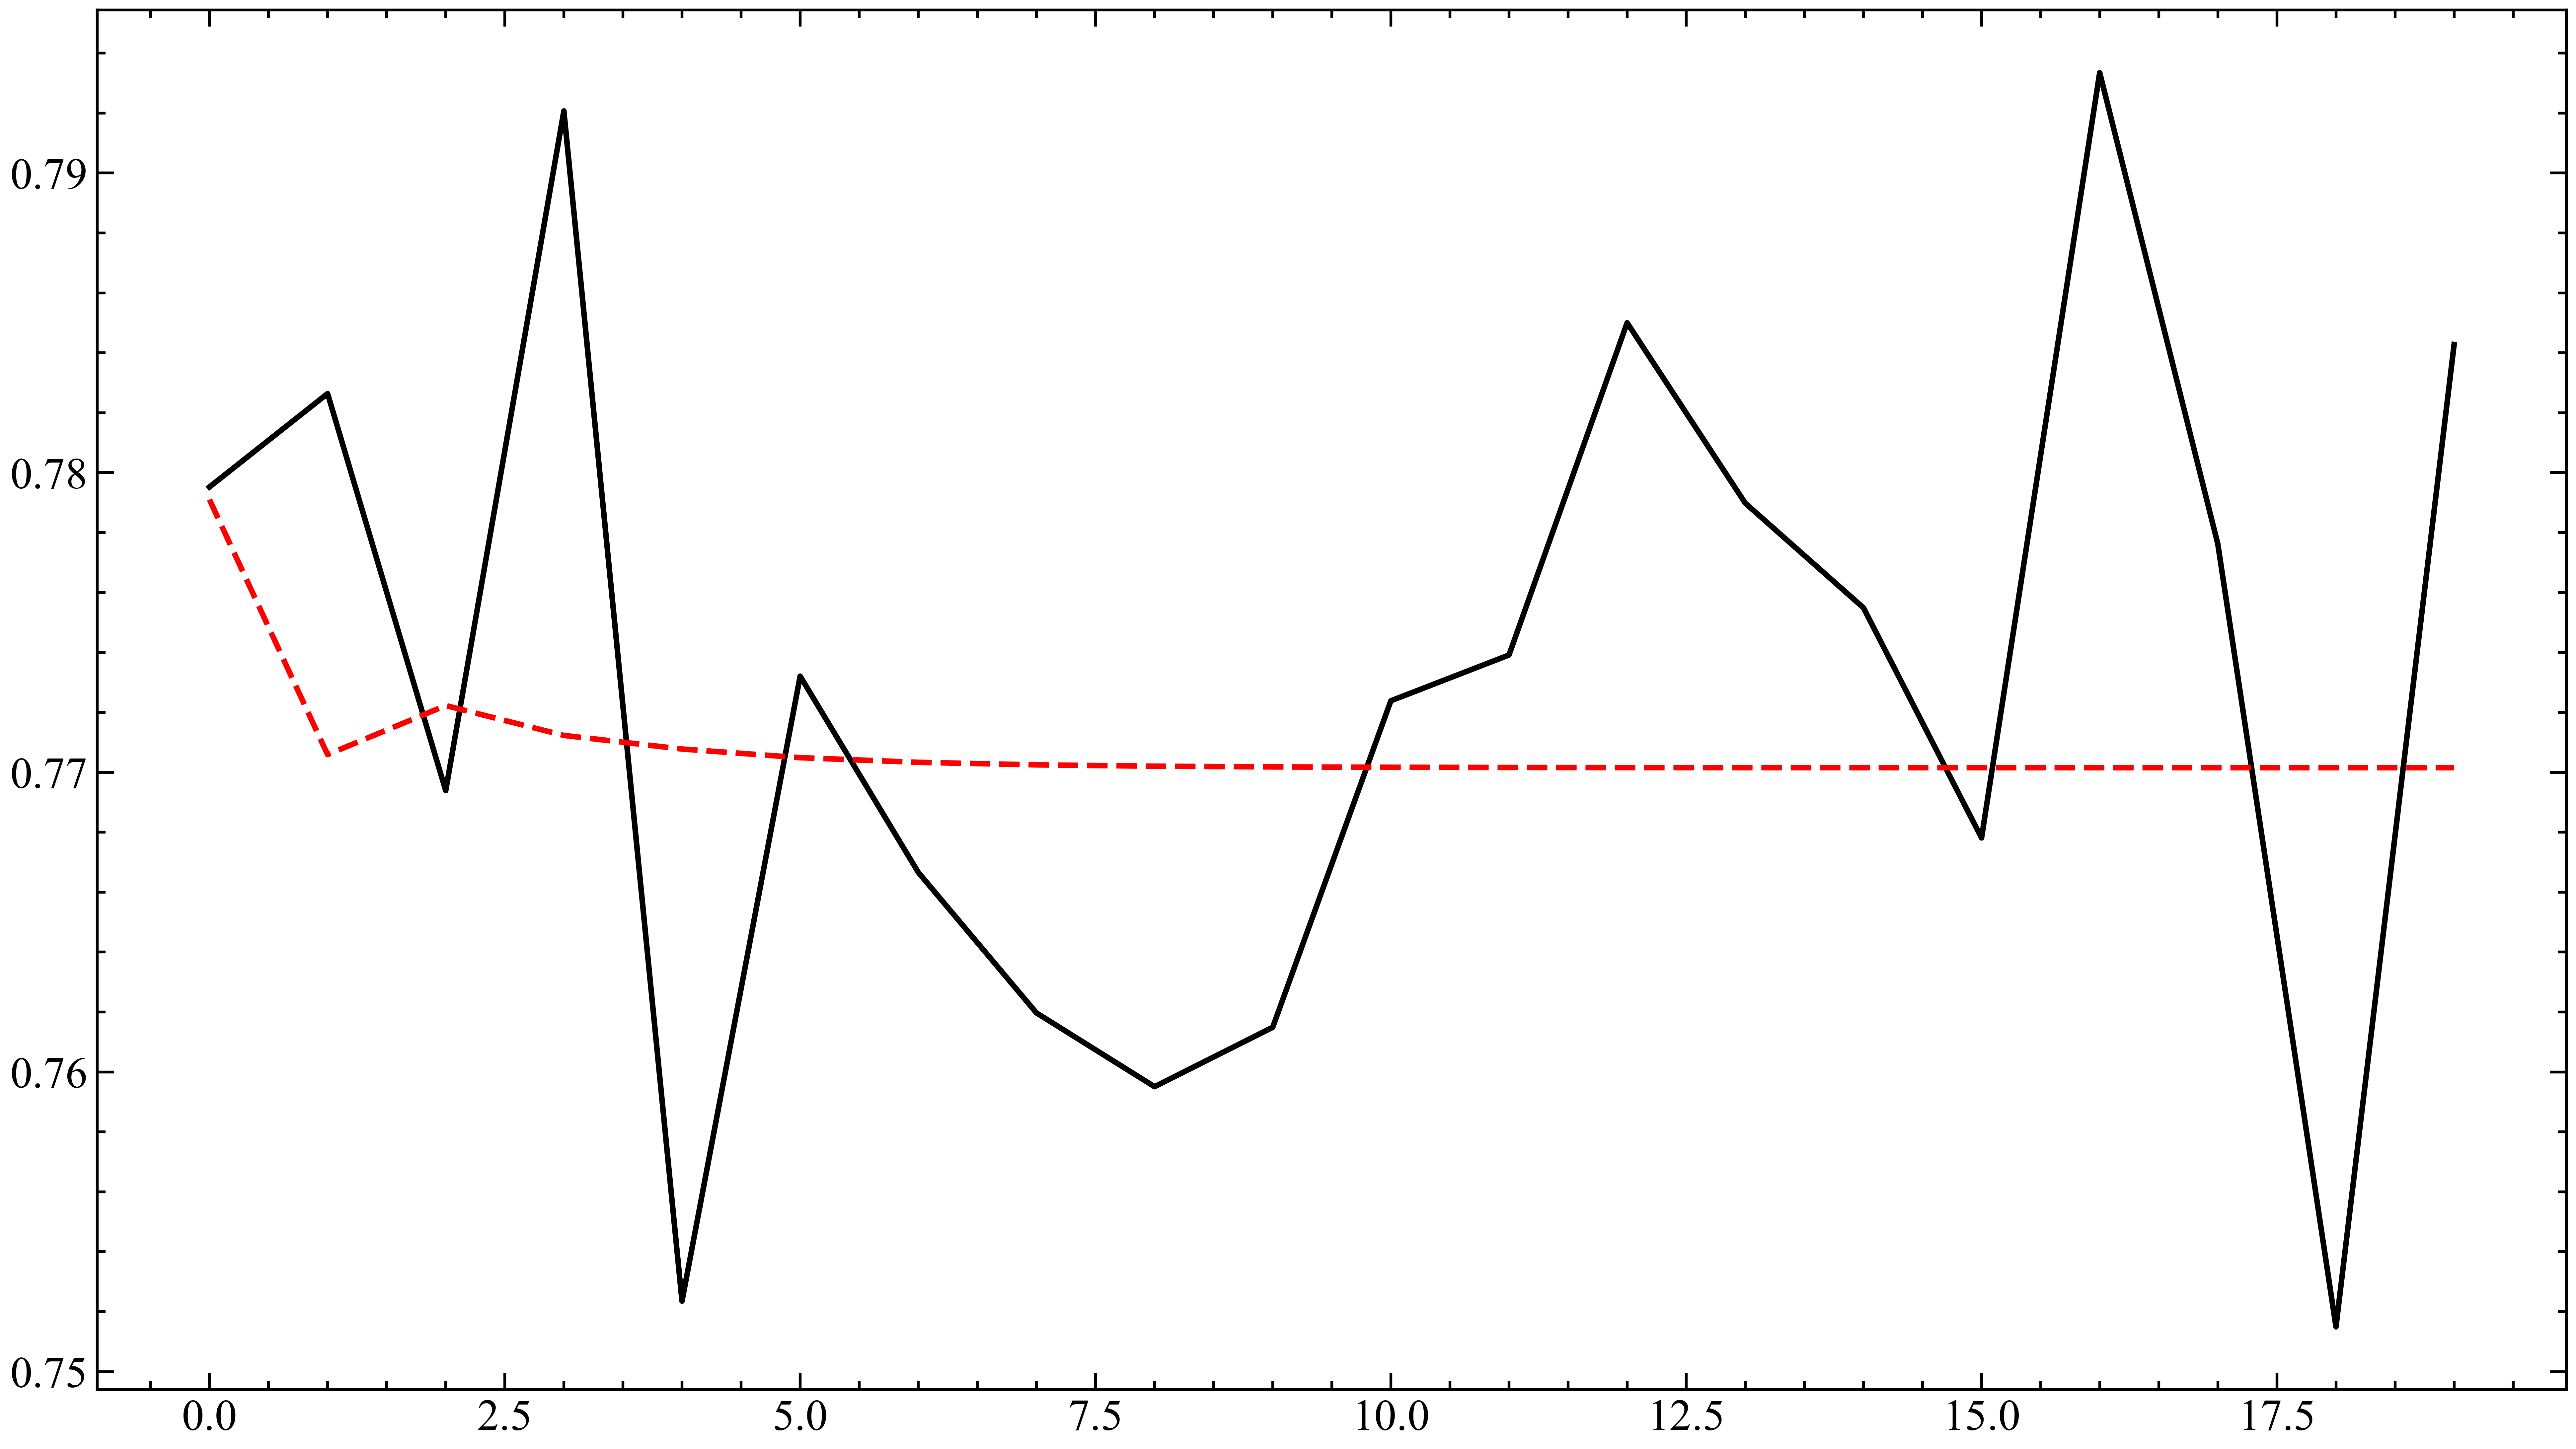

In [21]:
index: int = window_size * 100
plt.figure(figsize=(16, 9))
plt.plot(Xtrain_N[index])
plt.plot(predictions[index])

In [23]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/vinimelloemuller/TCC/e/TCC-1/metadata
